<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Importando LIBS</h2>
</div>

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import os
import glob

<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Configuração Inicial</h2>
</div>

In [2]:
LABEL_MAP = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# Nome da pasta de entrada com imagens
INPUT_FOLDER = "imagens_para_analise"
# Nome do arquivo de saída final
OUTPUT_FILENAME = "grade_resultados_gradcam.png"
# Caminho do modelo treinado
MODEL_PATH = "best_ResNet18_FineTuned.pth"
# Dispositivo para execução (CPU ou GPU) estou usando CPU por minha GPU não ser compatível
DEVICE = torch.device("cpu")

<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Definindo transformações e carregando modelos</h2>
</div>

In [3]:
transform_model = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_visual = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

print("Carregando o modelo...")
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print("Modelo carregado com sucesso.\n")

Carregando o modelo...
Modelo carregado com sucesso.



<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Processamento</h2>
</div>

Encontradas 4 imagens. Iniciando análise para criar a grade...

--- Processando imagem 1/4: imagem.jpg ---
--- Processando imagem 2/4: imagem2.jpg ---
--- Processando imagem 3/4: imagem3.jpg ---
--- Processando imagem 4/4: imagem4.jpg ---

Análise concluída! A grade de resultados foi salva em: 'grade_resultados_gradcam.png'


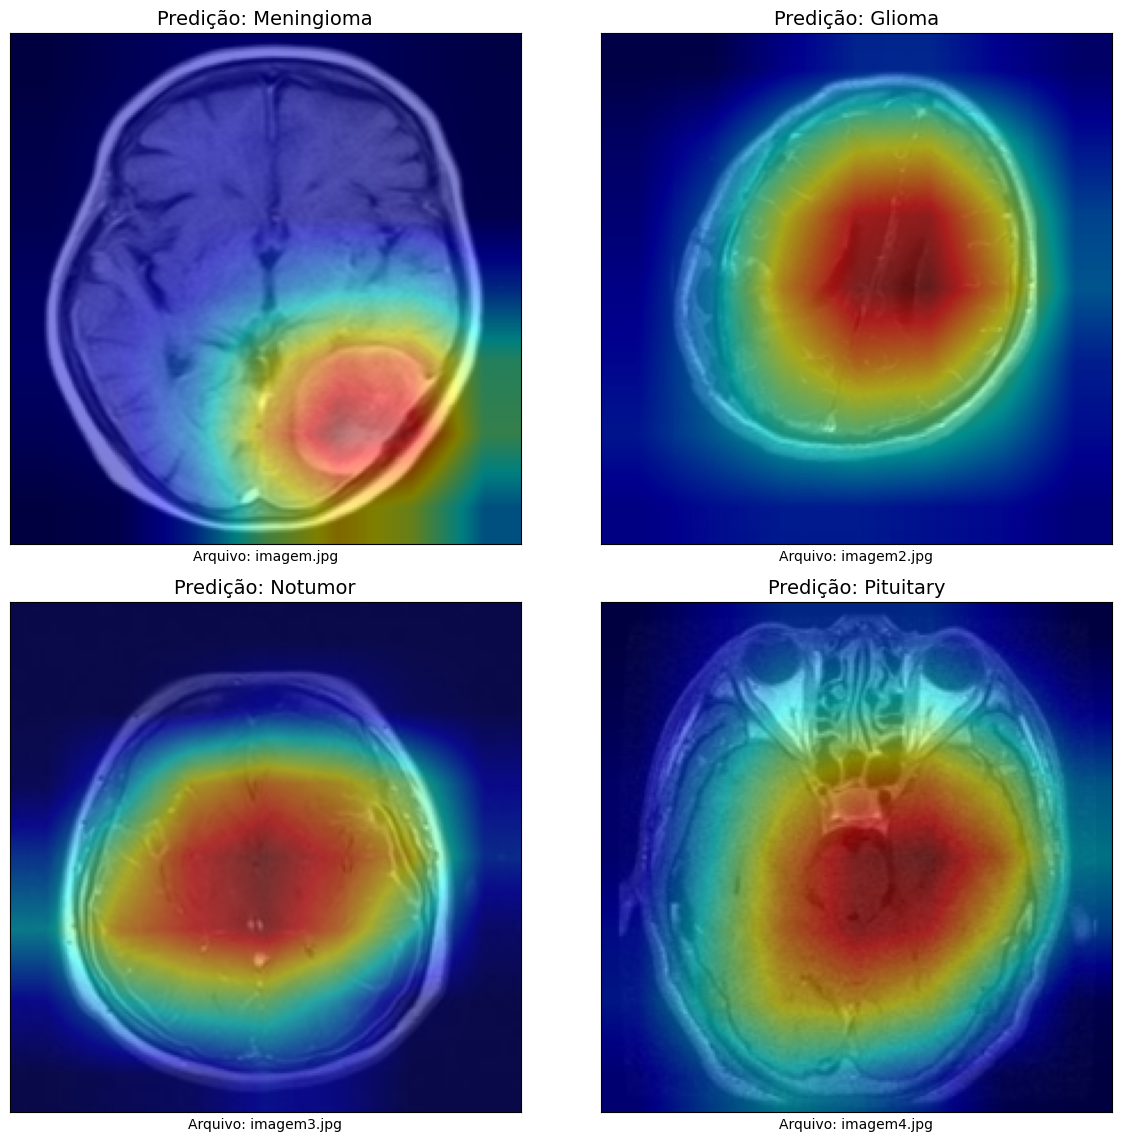

In [ ]:
image_paths = sorted(glob.glob(os.path.join(INPUT_FOLDER, '*.[jp][pn]g'))) # Sorted para ordem consistente

if len(image_paths) < 4:
    print(f"ERRO: Foram encontradas {len(image_paths)} imagens, mas são necessárias 4 para criar a grade 2x2.")
    exit()

print(f"Encontradas {len(image_paths)} imagens. Iniciando análise para criar a grade...\n")

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

for i, img_path in enumerate(image_paths[:4]):
    try:
        ax = axes[i]
        image_name = os.path.basename(img_path)
        print(f"--- Processando imagem {i+1}/4: {image_name} ---")

        # Preparação da Imagem para classificação e visualização
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform_model(image).unsqueeze(0).to(DEVICE)
        input_tensor.requires_grad_()
        image_for_visual = transform_visual(image).permute(1, 2, 0).numpy()

        # Inferência e Grad-CAM
        output = model(input_tensor)
        pred_index = output.argmax(dim=1).item()
        pred_class_name = INV_LABEL_MAP.get(pred_index, "Desconhecida")

        targets = [ClassifierOutputTarget(pred_index)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        visualization = show_cam_on_image(image_for_visual, grayscale_cam, use_rgb=True)

        # Plotando
        ax.imshow(visualization)
        ax.set_title(f"Predição: {pred_class_name.capitalize()}", fontsize=14)
        ax.set_xlabel(f"Arquivo: {image_name}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

    except Exception as e:
        print(f"Erro ao processar a imagem {img_path}: {e}\n")
        ax.set_title("Erro no Processamento")
        ax.axis('off')


plt.tight_layout(rect=[0, 0, 1, 0.96])

# Salvando e Exibindo
plt.savefig(OUTPUT_FILENAME, dpi=300)
print(f"\nAnálise concluída! A grade de resultados foi salva em: '{OUTPUT_FILENAME}'")

plt.show()